# 02 Clasificación multi-clase y clasificación multi-etiqueta

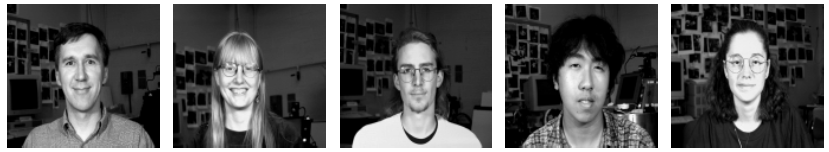

Esta actividad nos brinda la oportunidad de aplicar la técnica de redes neuronales al problema de reconocimiento de rostros. La actividad se divide en dos etapas.

- La `primer etapa` consiste en construir un modelo basado en redes neuronales para el reconocimiento de rostros en imágenes. Para este caso, se tienen tres clases: an2i, tammo y saavik. La actividad es guiada y utilizará el dataset: `faces.hdf5`.

- La `segunda etapa` consiste en construir un modelo basado en redes neuronales para identificar la postura del rostro que se encuentra en la imagen (de frente, arriba, izquierda, derecha). Esta actividad es idividual y utilizará el conjunto de imágenes que se encuentran en el archivo: `faces.zip`.

Las imágenes que utilizaremos, son rostros de estudiantes en la Universidad de Carnegie Mellon (curso de Machine Learning, profesor Tom Mitchel). Las imágenes son públicas y pueden ser descargadas de diversos repositorios en la web. Nosotros utilizaremos un subconjunto del dataset original, preparado para nuestra actividad.


## Etapa 1

Durante el desarrollo de la primera etapa de la actividad se abordaran los siguiente temas:

- Problema de clasificación multiclase y la representación de los datos (X, Y)
- Estructura de una red neuronal para clasificación multiclase
- Función de activación softmax
- Métricas de evaluación
- Implementación de una red neuronal utilizando Keras

### Descripción del problema

El problema que se aborda en esta etapa consiste en construir una red neuronal que permita identificar quién se encuentra en una imagen. Para esto, se dispone de un conjunto de fotos de los alumn@s: andi, tammo y saavik. Veamos una muestra de las imágenes:

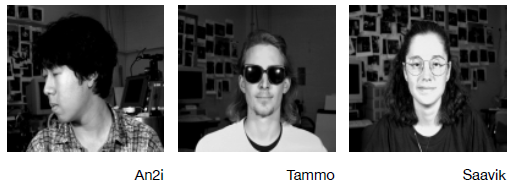

Considerando qué nuestro objetivo es identificar a quién pertenece el rostro que se encuentra en una imagen, para el desarrollo de esta actividad tendremos las siguientes clases:

<table>
  <tr align="left">
    <th>Clase 0</th>
    <td>An2i</th>
  </tr>
  <tr align="left">
    <th>Clase 1</th>
    <td>Tammo</th>
  </tr>

  <tr align="left">
    <th>Clase 2</th>
    <td>Saavik</th>
  </tr>
</table>

Para el desarrollo del modelo contamos con 282 imágenes. Las imágenes se encuentran almacenadas en el formato `pgm` y tienen las siguientes dimensionas: 30 x 32. Utilicemos la función `load_dataset()` que se encuentra definida en el archivo `utils.py` para cargar los datos almacenados en un archivo `hdf5`:

<table align="center">
  <tr>
    <th>X</th>
    <td>Conjunto de imágenes</th>
  </tr>
  <tr>
    <th>Y</th>
    <td>Clase real a la que pertenece cada imagen</th>
  </tr>
</table>


Veamos un ejemplo del uso de la función `load_dataset()`:

```Python
images, labels = load_dataset('dataset/faces.hdf5')
```

In [10]:
import w10_utils as w10
import numpy as np


In [32]:
# Cargar conjunto de datos
data_path = 'dataset/faces.hdf5'
images, labels = w10.load_dataset(data_path)
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input

In [14]:
#Verificamos la forma de los datos
print('images shape:', images.shape)
print('labels shape:', labels.shape)

print('images[0][0][0] Pixel from Img0 Top left:', images[0][0][0])
#Is an int num, therefore img is coded as rgb 0-255

images shape: (282, 30, 32)
labels shape: (282,)
images[0][0][0] Pixel from Img0 Top left: 5


### Preprocesamiento de los datos

Antes de comenzar con la construcción del modelo, necesitamos preparar los datos (etapa de preprocesamiento).


Para las imágenes (`Xo`):
- Todas las imágenes deben tener el mismo tamaño (30, 32)
- Representar cada imagen como un vector (flatten)
- Normalizar los pixeles de las imágenes

In [24]:
# Preprocesamiento de las imágenes

# 1. Flatten

images_vec = np.reshape(images, (282, 960))
print(images_vec.shape)

#No mezclamos los datos, ya que son imágenes y tienen una estructura espacial que queremos mantener
print(images[0][:2][:32])
print(images_vec[0][:64])

(282, 960)
[[ 5  0 28 50  0  0 56 26 11 14 12  6 34 19 25 47 10 32 47 57 33 43 41 35
  36 26 29 23 21 23 21 23]
 [45 55 66 51 43 44 49 16  2 18 27  5 30  8  7 48  7 19 12  6 27 14 22  2
  14  0  1 10  5 22 20 21]]
[ 5  0 28 50  0  0 56 26 11 14 12  6 34 19 25 47 10 32 47 57 33 43 41 35
 36 26 29 23 21 23 21 23 45 55 66 51 43 44 49 16  2 18 27  5 30  8  7 48
  7 19 12  6 27 14 22  2 14  0  1 10  5 22 20 21]


In [26]:
# 2. Normalization - Data from 0 to 1
image_vec = images_vec / 255.0

images_tf = tf.constant(images_vec, dtype=tf.float32)
print(images_tf.shape)

(282, 960)


Para las clases reales también llamadas etiquetas (`Y`) a las que pertenece cada imágen:
    
- Utilicemos la representación `one-hot-vector`

In [ ]:
# Originalmente Y contiene un valor: 0,1, o 2. Esto representa a qué clase pertenecen las imágenes
# 0 - an2i
# 1 - tammo
# 2 - saavik

# Abordaremos el problema como una clasificación multi-clase, por lo que conviene
# representar los valores de Y en el formato One Hot Vector,
# es decir, representaremos los elementos de Y como:

# 0  => [ 1 0 0 ]
# 1  => [ 0 1 0 ]
# 2  => [ 0 0 1 ]

In [29]:
# Realicemos la conversión
labels_vec = np.eye(3)[labels] # One Hot Vector
print(labels_vec.shape)


(282, 3)


In [30]:
# Comparemos la representación de las etiquetas
print(labels[:5])
print(labels_vec[:5])



[2 1 2 0 1]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


### Diseño de una red neuronal para clasificiación multiclase


In [33]:
# Utilicemos el API secuencial para construir nuestra red neuronal
# La red neuronal tendrá una capa de entrada de 256 neuronas, una capa oculta de 128 neuronas
# otra capa oculta de 64 neursonas, otra de 32, de 16  y una capa de salida de 3 neuronas
# con función de activación softmax
neural_network = tf.keras.Sequential([Input(shape=(960,)), Dense(256, activation='relu'),
                                      Dense(128, activation='relu'), Dense(64, activation='relu'),
                                      Dense(32, activation='relu'), Dense(16, activation='relu'),
                                      Dense(3, activation='softmax')])

# Compilamos el modelo
neural_network.compile(optimizer='sgd', loss='categorical_crossentropy')

# Entrenamos el modelo
neural_network.fit(images_vec, labels_vec, epochs=500)


neural_network.summary()





Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan      
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 10/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 11/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 12/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan 
Epoch 13/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 14/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 15/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 16/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: n

In [ ]:
# Verifique la diferencia entre utilizar la función de activación sigmoidal vs softmax en
# la capa de salida de nuestra red neuronal






### Implementación de la red utilizando Keras

In [ ]:
# Construyamos un modelo secuencial utilizando Keras (utilizando capas)





In [ ]:
#Entrenemos el modelo




In [ ]:
# Evaluemos el modelo utilizando como métrica la exactitud con datos de entrenamiento y prueba



In [ ]:
# Grafiquemos el comportamiento de la red neuronal durante el entrenamiento y validación

# Plot loss




# Plot categorical_accuracy




In [ ]:
# Realicemos algunas predicciones




In [ ]:
# Podemos implementar algunas funciones de utilería para convertir el número de clase en la étiqueta




In [ ]:
# Realicemos nuevamente algunas predicciones para visualizar las etiquetas



***¿Fin de la etapa uno de esta actividad!***

# Etapa 2

Hemos llegado a la `segunda etapa`, que  consiste en construir un modelo basado en redes neuronales para identificar la postura del rostro que se encuentra en la imagen (de frente, arriba, izquierda, derecha). Adicionalmente, su modelo deberá indicar si la persona de la imagen tiene lentes o no.

- Esta actividad es individual.

- Para construir su modelo utilizará el conjunto de imágenes que se encuentran en el archivo: `faces.zip`.

- Al finalizar su trabajo, entregue su implementación mediante CANVAS.
